In [7]:
%tensorflow_version 2.x
import tensorflow
tensorflow.__version__

'2.4.1'

Import Necessary Libraries

In [8]:
# Initialize the random number generator
import random
random.seed(0)

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

In [9]:
from matplotlib import pyplot as plt
from tensorflow import keras
%matplotlib inline
import numpy as np
import pandas as pd
import os as os
import sys
from PIL import Image
from array import array
import cv2 as cv2
from glob import glob
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers.convolutional import Conv2D, MaxPooling2D
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from keras.layers.core import Activation, Flatten, Dense
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.layers import BatchNormalization, Dropout

**Load the dataset from Google Drive**

In [11]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# **Question 1**

In [12]:
training_path = '/content/drive/MyDrive/Plant Seedling Classification Data/train'
test_path = '/content/drive/MyDrive/Plant Seedling Classification Data/test'
data_path = '/content/drive/MyDrive/Plant Seedling Classification Data/'

In [13]:
image_size = 75
def read_training_data(training_path):
  all_images = []
  labels = []
  img_folders = os.listdir( training_path ) 
  num_folders = len(img_folders)
  print(num_folders)

  for img_folder in img_folders:
    print(img_folder)
    path = training_path + '/' + img_folder + '/'
    files = os.listdir( path ) 
    for imgFile in files:
      imgPath = path + imgFile
      img = load_img(imgPath)
      arr = img_to_array(img)
      arr = cv2.resize(arr, (image_size, image_size))
      all_images.append(arr)
      labels.append(img_folder)
      
  return all_images, labels

In [14]:
image_size = 75
def read_test_data(test_path):
  all_images = []
  labels = []
  files = os.listdir( test_path ) 
  num_folders = len(files)
  print(num_folders)

  for imgFile in files:
    labels_df = pd.read_csv(data_path + 'sample_submission.csv')
    imgPath = test_path + '/' + imgFile
    img = load_img(imgPath)
    arr = img_to_array(img)
    arr = cv2.resize(arr, (image_size, image_size))
    all_images.append(arr)
    labels.append(labels_df[labels_df.file == imgFile].species)
    
  return all_images, labels

**Checking train data :**

In [15]:
train_data, train_labels = read_training_data(training_path)

12
Black-grass
Charlock
Cleavers
Common Chickweed
Common wheat
Fat Hen
Loose Silky-bent
Small-flowered Cranesbill
Scentless Mayweed
Sugar beet
Shepherds Purse
Maize


**The dataset has 12 species of plant seedlings.**

In [ ]:
len(train_labels)

In [ ]:
len(train_data)

4767

In [ ]:
train_data[1].shape

(75, 75, 3)

**Let's check test data**

In [ ]:
test_data, test_labels = read_test_data(test_path)

794


In [ ]:
len(test_labels)

794

In [ ]:
len(test_data)

794

In [ ]:
test_data[1].shape

**Visualizing some data :**

In [ ]:
plt.imshow(array_to_img(train_data[500]))
print("This is a", train_labels[500], "plant")

In [ ]:
plt.imshow(array_to_img(test_data[500]))
print("This is a", test_labels[500], "plant")

The image and lables seem to be in correct order.

In [ ]:
for i in range(12):
  plt.subplot(3,4, i+1)
  plt.imshow(array_to_img(train_data[i]))

**Data Processing**

In [ ]:
#Normalizing data
trainX = np.array(train_data, dtype="float") / 255.0
testX = np.array(test_data, dtype="float") / 255.0

In [16]:
#Convert target variable into categorical variable
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(train_labels)
encoded_labels = le.transform(train_labels)

In [ ]:
Y = np.array(encoded_labels)
trainY = tensorflow.keras.utils.to_categorical(Y, num_classes=12)

In [ ]:
print(trainY[4000])

In [ ]:
labels_df = pd.DataFrame(train_labels)
labels_df[0].value_counts().plot(kind='bar')

In [ ]:
labels_df = pd.DataFrame(encoded_labels)
labels_df[0].value_counts().plot(kind='bar')

In [ ]:
encoded_test_labels = le.transform(test_labels)
testY = np.array(encoded_test_labels)
testY = tensorflow.keras.utils.to_categorical(testY, num_classes=12)

In [ ]:
print(testY[160])

###**Implementing K-Nearest Neighbour Algorithm(k-NN)**

First we will run through supervised learning algorithm, wherein we will go with k-NN

In [ ]:
#Reshape data from 2D to 1D -> 75*75*3 to 16875
X_train = trainX.reshape(4767,16875)
X_test = testX.reshape(794,16875)
y_train = trainY
y_test = testY

In [ ]:
def create_supervised_learning_model():
#Initializing the value of k and finding the accuracies on validation data
  k_vals = range(1, 10, 2)
  accuracies = []

  for k in range(1, 10, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    score = knn.score(X_test, y_test)
    print("k value=%d, accuracy score=%.2f%%" % (k, score * 100))
    accuracies.append(score)
  
  # finding k with largest accuracy
  i = int(np.argmax(accuracies))
  print("k=%d value has highest accuracy of %.2f%% on validation data" % (k_vals[i],accuracies[i] * 100))
  return k_vals[i]

In [ ]:

i = create_supervised_learning_model()
knn = KNeighborsClassifier(n_neighbors=i)
knn.fit(X_train, y_train)
predictions = knn.predict(X_test)

In [ ]:

print("Evaluating test data : ")
print(classification_report(y_test, predictions))

Classification using KNN

In [ ]:
plt.figure(figsize=(2,2))
plt.imshow(testX[700])
plt.show()
image = X_test[700]
print(knn.predict(image.reshape(1, -1)))
print(y_test[700])

###**Implementing Neural Network**

After k-NN which is supervised algorithm, now we will go through Neural Network

In [ ]:
#Reshape data from 2D to 1D -> 75*75*3 to 16875
X_train = trainX.reshape(4767,16875)
X_test = testX.reshape(794,16875)
y_train = trainY
y_test = testY

In [ ]:
def nn_model():
  output_nodes = 12
  model = Sequential()
  model.add(Dense(512, input_shape=(16875,), activation='relu', kernel_initializer='he_normal'))
  model.add(BatchNormalization())
  model.add(Dropout(0.25))
  model.add(Dense(256, activation='relu', kernel_initializer='he_normal'))
  model.add(BatchNormalization())
  model.add(Dropout(0.25))
  model.add(Dense(128, activation='relu', kernel_initializer='he_normal'))
  model.add(BatchNormalization())
  model.add(Dropout(0.25))
  model.add(Dense(64, activation='relu', kernel_initializer='he_normal'))
  model.add(BatchNormalization())
  model.add(Dense(32, activation='relu', kernel_initializer='he_normal'))
  model.add(Dense(output_nodes, activation='softmax'))
  adam = optimizers.Adam(lr = 0.001)
  
  model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

  
  return model

In [ ]:
nn_model = nn_model()
nn_model.fit(X_train, y_train, epochs=20, batch_size=100, verbose= 1)

In [ ]:
# Let's view parameters and all the layers
nn_model.summary()

In [ ]:
score = nn_model.evaluate(X_train, y_train, verbose=0)
print("Accuaracy on training data:", score[1])
results = nn_model.evaluate(X_test, y_test)
print("Test Accuracy: ", results[1])

We clearly see that there occurs problem of overfitting. So we need to ponder upon more advanced algorithms. So now we will run it through our CNN model.

###**Implementing CNN Model**

In [ ]:
img_size=128

In [ ]:
def create_cnn_model1():
  output_nodes = 12
  model = Sequential()
  
  model.add(BatchNormalization(input_shape=(img_size, img_size, 3)))
  # Our CONV  layer will learn 20 convolution filters, each of 5X5
  model.add(Conv2D(32, (3, 3), padding="same",activation='relu'))
  #To visualize this operation, consider a sliding window that “slides” across the input size both horizontally and vertically.
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))

  #This time we are learning 50 convolutional filters rather than the 20 as in the previous layer.
  model.add(BatchNormalization())
  model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))

  model.add(BatchNormalization())
  model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))
  
  model.add(Flatten())
  model.add(Dense(512, activation='relu'))

  # softmax classifier
  model.add(Dense(output_nodes, activation='softmax'))
  # returns our fully constructed deep learning + Keras image classifier 
  #opt = optimizers.Adam(lr=0.001)
  # use binary_crossentropy if there are two classes
  model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])
  return model

We are going to use data generator to load images from directory in batches which will help in memory optimization.

In [ ]:
train_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=20,  \
                                                                       width_shift_range = 0.2,height_shift_range=0.1, horizontal_flip=True)
train_gen = train_data_generator.flow_from_directory(training_path, target_size=(img_size,img_size))

In [ ]:
testdf = pd.read_csv(data_path + 'sample_submission.csv',dtype=str)
test_datagen = ImageDataGenerator()
test_gen = test_datagen.flow_from_dataframe(dataframe=testdf, directory=test_path,\
                                            x_col="file",y_col='species', batch_size=32, seed=1, shuffle=False,target_size=(img_size, img_size))

In [ ]:
# initialize the model
print("compiling model...")

model = create_cnn_model1()
# define checkpoint
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/models/plant_cnn.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

In [ ]:
model.summary()

In [ ]:
model.fit(train_gen, epochs=35, steps_per_epoch= 4767//32, validation_data=test_gen, validation_steps = 794//32, callbacks=[model_checkpoint])

# **Question 2**

Explain  in  depth  why  CNN  out  performs  neural  networks  which  in  turn  out  perform  supervised  learning models when it comes to image classification.

Ans. We see that in supervised algorithm (k-NN) which we used, there occurred a problem of overfitting. Following on with Neural Netowrks, it uses weights to learn which get changeds after each iteration through the neuron based on the accuracy calculated by a “cost function.”

However, there is no neuron or weights in CNN. CNN instead uses multiple layers on images and uses filtration to analyze image inputs. These layers understand patterns in the network, process output of data, and provide an n-dimensional vector output. That n-dimensional output is used to observe distinct features and connect them with the image input provided. It can then give the classification output to the user. Thus, CNN becomes much more powerful and accurate as compared to supervised algorithms and also nueral networks.

# **Question 3**

A  brand  research  company  wants  to  understand  which  cars  or  car  manufacturers  are  popular  in  a certain area of the city or locality. Company has a team which takes pictures of the cars randomly through the day.  Using  this  the  company  wants  to  set  up  an  automation  which  can  classify  the  make  of  the  car  once  the picture has been given as an input.

In [ ]:
cars_images_path = '/content/drive/MyDrive/Cars Images/'

In [ ]:
img_size = 128

In [ ]:
def read_car_data(path):
  all_images = []
  file_names = []
  files = os.listdir(path) 
  num_folders = len(files)
  print(num_folders)

  for imgFile in files:
    print(imgFile)
    file_names.append(imgFile)
    imgPath = path + '/' + imgFile
    img = load_img(imgPath)
    arr = img_to_array(img)
    arr = cv2.resize(arr, (img_size, img_size))
    all_images.append(arr)
    
  return all_images, file_names

In [ ]:
car_images, file_names = read_car_data(cars_images_path)

15
00011.jpg
00006.jpg
00014.jpg
00008.jpg
00005.jpg
00004.jpg
00009.jpg
00013.jpg
00015.jpg
00007.jpg
00003.jpg
00002.jpg
00001.jpg
00010.jpg
00012.jpg


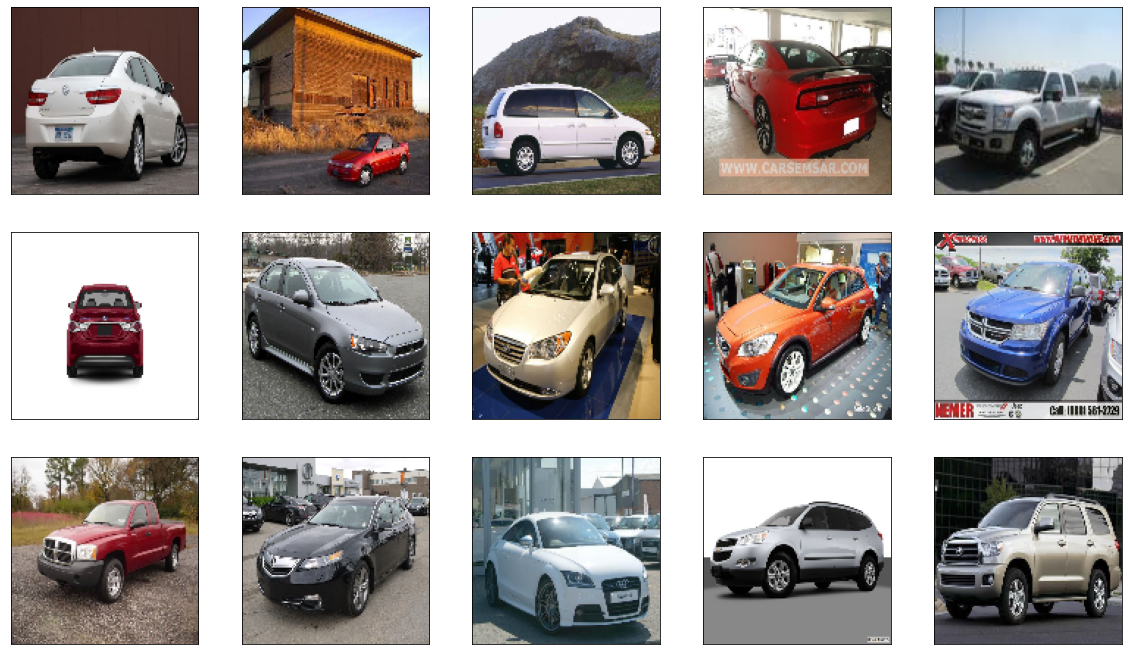

In [ ]:
plt.figure(figsize=(20,20))
for i in range(len(car_images)):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(array_to_img(car_images[i]/255), cmap=plt.cm.binary)

In [ ]:
df = pd.DataFrame(columns=('file','Car_Brand'))

In [ ]:
df.file = file_names

In [ ]:
df.head(15)

,file,Car_Brand
0,00011.jpg,Chevrolet
1,00006.jpg,NaN
2,00014.jpg,NaN
3,00008.jpg,Dodge
4,00005.jpg,NaN
5,00004.jpg,Toyota
6,00009.jpg,Mitsubishi
7,00013.jpg,Hyundai
8,00015.jpg,Nissan
9,00007.jpg,Dodge


In [ ]:
df.loc[df.file.eq('00001.jpg'), 'Car_Brand'] = 'Audi'
df.loc[df.file.eq('00002.jpg'), 'Car_Brand'] = 'Acura'
df.loc[df.file.eq('00004.jpg'), 'Car_Brand'] = 'Toyota'
df.loc[df.file.eq('00007.jpg'), 'Car_Brand'] = 'Dodge'
df.loc[df.file.eq('00008.jpg'), 'Car_Brand'] = 'Dodge'
df.loc[df.file.eq('00009.jpg'), 'Car_Brand'] = 'Mitsubishi'
df.loc[df.file.eq('00010.jpg'), 'Car_Brand'] = 'Chevrolet'
df.loc[df.file.eq('00011.jpg'), 'Car_Brand'] = 'Chevrolet'
df.loc[df.file.eq('00012.jpg'), 'Car_Brand'] = 'Toyota'
df.loc[df.file.eq('00013.jpg'), 'Car_Brand'] = 'Hyundai'
df.loc[df.file.eq('00015.jpg'), 'Car_Brand'] = 'Nissan'

In [ ]:
df.to_csv('/content/drive/MyDrive/models/car_labels.csv')

Here, we have labels mapping with each car with its image for classification.

# **Question 4**

University  X  is  currently  undergoing  some  research  involving  understanding  the  characteristics  of flowers.  They  already  have  have  invested  on  curating  sample  images.  They  require  an  automation  which  can create a classifier capable of determining a flower’s species from a photo.

In [ ]:
assert(tf.test.gpu_device_name())

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
!pip install tflearn

In [ ]:
import tflearn.datasets.oxflower17 as oxflower17

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
#Load data
X, Y = oxflower17.load_data(one_hot=True)

In [ ]:
X.shape

(1360, 224, 224, 3)

In [ ]:
Y.shape

(1360, 17)

In [ ]:
X[100]

array([[[0.57254905, 0.5803922 , 0.53333336],
        [0.48235294, 0.49411765, 0.4509804 ],
        [0.49411765, 0.49411765, 0.46666667],
        ...,
        [0.10980392, 0.11764706, 0.10588235],
        [0.13725491, 0.14117648, 0.13725491],
        [0.15294118, 0.14901961, 0.15294118]],

       [[0.53333336, 0.5411765 , 0.49411765],
        [0.44313726, 0.44705883, 0.4117647 ],
        [0.4392157 , 0.44313726, 0.4117647 ],
        ...,
        [0.11764706, 0.1254902 , 0.11372549],
        [0.1254902 , 0.12941177, 0.12156863],
        [0.13333334, 0.13333334, 0.13725491]],

       [[0.36862746, 0.3764706 , 0.33333334],
        [0.36078432, 0.36862746, 0.32941177],
        [0.45882353, 0.4627451 , 0.43137255],
        ...,
        [0.1254902 , 0.13725491, 0.1254902 ],
        [0.12156863, 0.1254902 , 0.11764706],
        [0.12941177, 0.12941177, 0.13333334]],

       ...,

       [[0.69411767, 0.7058824 , 0.67058825],
        [0.7490196 , 0.7607843 , 0.7254902 ],
        [0.7490196 , 0

In [ ]:
print(Y[10])
# its in categorical format which is required for this problem

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [ ]:

trainX = X

In [ ]:
#Normalizing data
print(trainX.max())
print(trainX.min())

1.0
0.0


**Data Visualization**

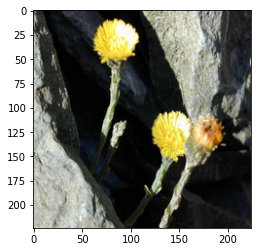

In [ ]:
plt.imshow(array_to_img(X[100]))

In [ ]:
print(Y[100])

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
actual_labels = Y.argmax(1)

In [ ]:
actual_labels[10]

12

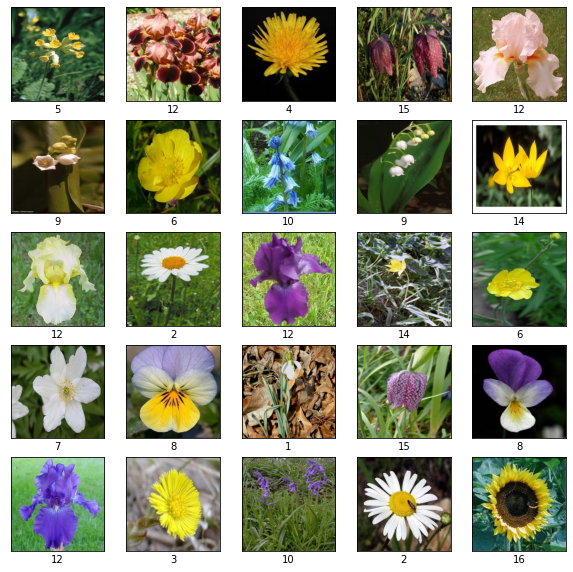

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10)) 
# plot 50 images
for i in range(50):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(array_to_img(trainX[i]/255), cmap=plt.cm.binary)
    plt.xlabel(actual_labels[i])

**Applying some filters on image**

In [ ]:
filterX=[]
for i in range(len(trainX)):
  sharpenKernel = np.array(([[0, -1, 0], [-1, 9, -1], [0, -1, 0]]), np.float32)/9
  sharpened_image = cv2.filter2D(src=trainX[i], kernel=sharpenKernel, ddepth=-1)
  img = cv2.GaussianBlur(sharpened_image, (5, 5), 0)
  filterX.append(img)  
trainX=np.array(filterX)

In [ ]:
# checking shape post filter
trainX.shape

(1360, 224, 224, 3)

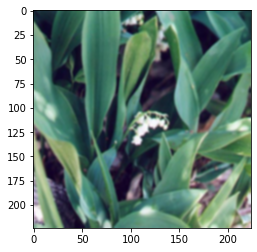

In [ ]:
plt.imshow(array_to_img(trainX[500]))

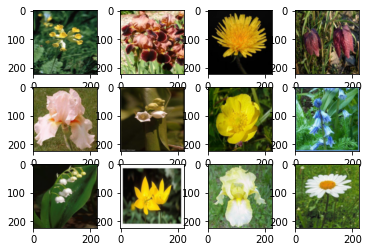

In [ ]:
for i in range(12):
  plt.subplot(3,4, i+1)
  plt.imshow(array_to_img(trainX[i]))

 - Data seems to be in normalized format.

Split the data

In [ ]:

from sklearn.model_selection import train_test_split
Xtrain, Xtest, y_train, y_test = train_test_split(trainX, Y, 
                                                test_size=0.20, random_state=1, 
                                                stratify = Y)

In [ ]:

print(Xtrain.shape)
print(Xtest.shape)

(1088, 224, 224, 3)
(272, 224, 224, 3)


**Implementing K Nearest Neighbour Algorithm**

We will start with supervised algorithm and choose k-NN for the same.

In [ ]:
#Reshape data from 2D to 1D -> 128*128*3 to 49152
X_train = Xtrain.reshape(1088,150528)
X_test = Xtest.reshape(272,150528)

In [ ]:
def create_supervised_learning_model():
  # Initializing the value of k and finding the accuracies on validation data
  k_vals = range(1, 10, 2)
  accuracies = []

  for k in range(1, 10, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    score = knn.score(X_test, y_test)
    print("k value=%d, accuracy score=%.2f%%" % (k, score * 100))
    accuracies.append(score)
  
  # finding k with largest accuracy
  i = int(np.argmax(accuracies))
  print("k=%d value has highest accuracy of %.2f%% on validation data" % (k_vals[i],accuracies[i] * 100))
  return k_vals[i]

In [ ]:
n = create_supervised_learning_model()

k value=1, accuracy score=37.13%
k value=3, accuracy score=20.96%
k value=5, accuracy score=18.01%
k value=7, accuracy score=12.13%
k value=9, accuracy score=10.29%
k=1 value has highest accuracy of 37.13% on validation data


In [ ]:
#Retraining the model using the best k value and predict the labels on test data
k_vals = range(1, 10, 2)
knn = KNeighborsClassifier(n_neighbors=n)
knn.fit(X_train, y_train)
predictions = knn.predict(X_test)

In [ ]:
#classification report showing the accuracy of the classifier
print("Testing data evaluation :")
print(classification_report(y_test, predictions))

EVALUATION ON TESTING DATA
              precision    recall  f1-score   support

           0       0.35      0.38      0.36        16
           1       0.20      0.12      0.15        16
           2       0.69      0.56      0.62        16
           3       0.56      0.31      0.40        16
           4       0.53      0.56      0.55        16
           5       0.19      0.44      0.27        16
           6       0.32      0.56      0.41        16
           7       0.54      0.44      0.48        16
           8       0.70      0.44      0.54        16
           9       0.17      0.12      0.14        16
          10       0.35      0.38      0.36        16
          11       0.33      0.06      0.11        16
          12       0.62      0.81      0.70        16
          13       0.30      0.19      0.23        16
          14       0.06      0.12      0.08        16
          15       0.40      0.38      0.39        16
          16       1.00      0.44      0.61        16


Classification using KNN

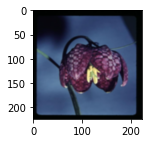

[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
plt.figure(figsize=(2,2))
plt.imshow(array_to_img(Xtest[200]))
plt.show()
image = X_test[50]
print(knn.predict(image.reshape(1, -1)))
print(y_test[50])

**Implementing Neural Network**

In [ ]:
X_train = Xtrain.reshape(1088,150528)
X_test = Xtest.reshape(272,150528)

In [ ]:
def nn_model_1():
  output_nodes = 17
  model = Sequential()
  model.add(BatchNormalization(input_shape=(150528,)))
  model.add(Dense(256, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.25))
  model.add(Dense(256, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.25))
  model.add(Dense(128, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.25))
  model.add(Dense(64, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.25))
  model.add(Dense(32, activation='relu', kernel_initializer='he_normal'))
  model.add(Dense(output_nodes, activation='softmax'))
  adam = optimizers.Adam(lr = 0.001)
  # Compile model
  model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

  # Fit the model
  return model

In [ ]:
nn_model = nn_model_1()
nn_model.fit(X_train, y_train, epochs=20, batch_size=100, verbose= 1)

Train on 1088 samples
Epoch 1/20
1088/1088 [==============================] - 1s 828us/sample - loss: 3.3289 - acc: 0.0836
Epoch 2/20
1088/1088 [==============================] - 1s 543us/sample - loss: 2.9223 - acc: 0.1452
Epoch 3/20
1088/1088 [==============================] - 1s 523us/sample - loss: 2.6739 - acc: 0.1903
Epoch 4/20
1088/1088 [==============================] - 1s 508us/sample - loss: 2.4797 - acc: 0.2316
Epoch 5/20
1088/1088 [==============================] - 1s 523us/sample - loss: 2.3447 - acc: 0.2509
Epoch 6/20
1088/1088 [==============================] - 1s 512us/sample - loss: 2.2671 - acc: 0.2665
Epoch 7/20
1088/1088 [==============================] - 1s 534us/sample - loss: 2.1620 - acc: 0.3079
Epoch 8/20
1088/1088 [==============================] - 1s 512us/sample - loss: 2.0605 - acc: 0.3346
Epoch 9/20
1088/1088 [==============================] - 1s 505us/sample - loss: 1.9741 - acc: 0.3529
Epoch 10/20
1088/1088 [==============================] - 1s 523us/sam

In [ ]:
score = nn_model.evaluate(X_train, y_train, verbose=0)
print("Accuaracy on training data:", score[1])

Accuaracy on training data: 0.3290441


In [ ]:
results = nn_model.evaluate(X_test, y_test)
print("Test Accuracy: ", results[1])

Test Accuracy:  0.20588236


In [ ]:
nn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 150528)            602112    
_________________________________________________________________
dense (Dense)                (None, 256)               38535424  
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0

**Implementing CNN Model**

In [ ]:
img_size = 224

In [ ]:
def create_cnn_model1():
  output_nodes = 17
  model = Sequential()
  
  model.add(BatchNormalization(input_shape=(img_size, img_size, 3)))
  # The CONV  layer will learn 20 convolution filters, each of which are 5×5.
  model.add(Conv2D(32, (3, 3), padding="same",activation='relu'))
  #To visualize this operation, consider a sliding window that “slides” across the input size, both horizontally and vertically.
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))
  #This time we are learning 50 convolutional filters rather than the 20 used in previous layer set.
  model.add(BatchNormalization())
  model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))

  model.add(BatchNormalization())
  model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(Dense(512, activation='relu'))

  # softmax classifier
  model.add(Dense(output_nodes, activation='softmax'))
  opt = optimizers.Adam(lr=0.001)
  model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
  return model

In [ ]:
#Let's split the data again
from sklearn.model_selection import train_test_split
Xtrain, Xtest, y_train, y_test = train_test_split(trainX, Y, 
                                                test_size=0.20, random_state=1, 
                                                stratify = Y)

In [ ]:
#construct the image generator for data augmentation
print("Generating images...")

data_gen = ImageDataGenerator(rotation_range=30, width_shift_range=0.1, \
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,\
    horizontal_flip=True, fill_mode="nearest")

# initialize the model
print("compiling model...")

model = create_cnn_model1()
# define checkpoint
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/models/flower_cnn.h5', save_best_only=True, monitor='val_acc', mode='max', verbose=1)

Generating images...
compiling model...


In [ ]:
history_A = model.fit_generator(data_gen.flow(Xtrain, y_train, batch_size=75), epochs=35, validation_data=(Xtest, y_test), verbose=2, callbacks = [model_checkpoint])

Epoch 1/35

Epoch 00001: val_acc improved from -inf to 0.05515, saving model to flower_cnn.h5
15/15 - 13s - loss: 88.7359 - acc: 0.0579 - val_loss: 4.4167 - val_acc: 0.0551
Epoch 2/35

Epoch 00002: val_acc improved from 0.05515 to 0.10662, saving model to flower_cnn.h5
15/15 - 11s - loss: 15.8078 - acc: 0.0699 - val_loss: 2.8181 - val_acc: 0.1066
Epoch 3/35

Epoch 00003: val_acc did not improve from 0.10662
15/15 - 11s - loss: 3.8501 - acc: 0.0836 - val_loss: 2.8369 - val_acc: 0.0478
Epoch 4/35

Epoch 00004: val_acc did not improve from 0.10662
15/15 - 11s - loss: 2.6664 - acc: 0.1296 - val_loss: 2.8691 - val_acc: 0.0588
Epoch 5/35

Epoch 00005: val_acc did not improve from 0.10662
15/15 - 11s - loss: 2.5075 - acc: 0.1765 - val_loss: 2.9084 - val_acc: 0.0588
Epoch 6/35

Epoch 00006: val_acc did not improve from 0.10662
15/15 - 11s - loss: 2.4311 - acc: 0.1765 - val_loss: 2.9175 - val_acc: 0.0588
Epoch 7/35

Epoch 00007: val_acc did not improve from 0.10662
15/15 - 11s - loss: 2.3824 - 

In [ ]:
results_1 = model.evaluate(Xtest, y_test)
print("Test Accuracy: ", results_1[1])

Test Accuracy:  0.47058824


**Implement CNN model using Transfer Learning**

In [ ]:
#Let's split the data again
from sklearn.model_selection import train_test_split
Xtrain, Xtest, y_train, y_test = train_test_split( trainX, Y, 
                                                test_size=0.20, random_state=1, 
                                                stratify = Y)

In [ ]:
Xtrain.shape

(1088, 224, 224, 3)

In [ ]:
Xtest.shape

(272, 224, 224, 3)

In [ ]:
y_test.shape

(272, 17)

In [ ]:
def normalize_data(img):
  return tf.keras.applications.resnet50.preprocess_input(img)

In [ ]:
train_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, rotation_range=20,  \
                                                                       width_shift_range = 0.2,height_shift_range=0.1, horizontal_flip=True,
                                                                       preprocessing_function=normalize_data)

test_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, preprocessing_function=normalize_data)

In [ ]:
resnet_conv = tf.keras.applications.ResNet50(include_top=False, input_shape=(img_size,img_size,3), weights='imagenet')

In [ ]:
for layer in resnet_conv.layers[140:]:
  layer.trainable = True

In [ ]:
x = resnet_conv.output
x1 = tf.keras.layers.GlobalAveragePooling2D()(x)
prediction = tf.keras.layers.Dense(17,activation='softmax')(x1)

In [ ]:
final_model = tf.keras.models.Model(inputs=resnet_conv.input,outputs=prediction)

In [ ]:
opt = optimizers.Adam(lr=0.00001)
final_model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [ ]:
#pretrained_model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/models/flower_resnet50.h5', save_best_only=True, monitor='val_acc', mode='max', verbose=1)

In [ ]:
history_A = final_model.fit_generator(train_data_generator.flow(Xtrain, y_train), 
                                      epochs=35, validation_data=test_data_generator.flow(Xtest, y_test), verbose=2, callbacks = [model_checkpoint])

Epoch 1/35

Epoch 00001: val_acc did not improve from 0.05882
34/34 - 30s - loss: 0.0530 - acc: 0.9871 - val_loss: 8.4692 - val_acc: 0.0588
Epoch 2/35

Epoch 00002: val_acc did not improve from 0.05882
34/34 - 14s - loss: 0.0399 - acc: 0.9899 - val_loss: 8.3675 - val_acc: 0.0588
Epoch 3/35

Epoch 00003: val_acc did not improve from 0.05882
34/34 - 17s - loss: 0.0317 - acc: 0.9945 - val_loss: 8.6455 - val_acc: 0.0588
Epoch 4/35

Epoch 00004: val_acc did not improve from 0.05882
34/34 - 16s - loss: 0.0340 - acc: 0.9917 - val_loss: 8.8517 - val_acc: 0.0588
Epoch 5/35

Epoch 00005: val_acc did not improve from 0.05882
34/34 - 16s - loss: 0.0307 - acc: 0.9926 - val_loss: 8.8607 - val_acc: 0.0588
Epoch 6/35

Epoch 00006: val_acc did not improve from 0.05882
34/34 - 16s - loss: 0.0207 - acc: 0.9954 - val_loss: 9.3271 - val_acc: 0.0588
Epoch 7/35

Epoch 00007: val_acc did not improve from 0.05882
34/34 - 16s - loss: 0.0202 - acc: 0.9954 - val_loss: 9.4186 - val_acc: 0.0588
Epoch 8/35

Epoch 00

In [ ]:
results = final_model.evaluate(test_data_generator.flow(Xtest, y_test))
print("Test Accuracy: ", results[1])

Test Accuracy:  0.8419118


In [ ]:
final_model.save('/content/drive/MyDrive/models/resnet_final_model.h5')
final_model.save_weights('/content/drive/MyDrive/models/')

In [ ]:
final_model.save_weights('/content/drive/MyDrive/models/wts')

# **Question 5**

Explain in depth your strategy to maintain and support the AIML image classifier after it in production.

Ans. Model Montioring after deployment in production is very crucial to ensure we get the right results.Model Its a stage in the machine learning life cycle that comes after model deployment, and deals with errors, crashes, and latency, but most importantly, to ensure that your model is maintaining a predetermined desired level of performance.

The reason of model montioring is that models degrade over time referred as model drift. Model Drift, also known as model decay, refers to the degradation of a model’s prediction power due to various reasons like unseen data, change in relationship between variables, etc.

We can have reinforcemnet learning to make our model robust.

In addition to that, we can identify input samples which deviate significantly from the patterns seen in the training data and then have those samples closely examined by a human expert.

We can also implement 2 approaches : Proactive and Reactive

where proactive model maintenance identifies general patterns in the test data which are outliers compared to those in the training data, while goal of Reactive Model Maintenance is to identify what led to an erroneous output in a specific test sample and how it can be rectified.

